In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import statsmodels.api as sm
from tqdm import tqdm
from statsmodels.tsa.api import VAR
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Supply side data
- crude oil production
- crude oil inventory
- natural gas production
- natural gas invetory
- dry gas prod
- gas rig count
- LNG exports

We will use below as speculative variables for energy:
- VIX	->	Measures investor fear, affecting financial flows into oil.
- USD -> strength alters oil’s financial attractiveness but also affects real demand.
- S&P 500	-> Risk appetite drives herd behavior in commodities.
- GEPU	-> Policy uncertainty → Speculative hoarding/avoidance.

In [ ]:
# 1
wti_spot = pd.read_csv('/content/Cushing_OK_WTI_Spot_Price_FOB.csv', on_bad_lines='skip')
wti_spot['Month'] = pd.to_datetime(wti_spot['Month'], format='%b-%y')
wti_spot = wti_spot[(wti_spot['Month'].dt.year >= 2000) & (wti_spot['Month'].dt.year <= 2024)]
wti_spot.index = range(1, len(wti_spot) + 1)

# 2
ng_spot = pd.read_csv('/content/Henry_Hub_Natural_Gas_Spot_Price.csv')
ng_spot['Month'] = pd.to_datetime(ng_spot['Month'], format='%b-%y')
ng_spot = ng_spot[(ng_spot['Month'].dt.year >= 2000) & (ng_spot['Month'].dt.year <= 2024)]
ng_spot.index = range(1, len(wti_spot) + 1)

# 3
gepu = pd.read_excel('/content/Global_Policy_Uncertainty_Data.xlsx')
gepu = gepu.dropna(subset=['Year', 'Month']).copy()
gepu['Year'] = pd.to_numeric(gepu['Year'], errors='coerce')
gepu = gepu[(gepu['Year'] >= 2000) & (gepu['Year'] <= 2024)]
gepu = gepu.sort_values(by=['Year', 'Month'], ascending=False)
gepu = pd.DataFrame(gepu['GEPU_current'])
gepu.index = range(1, len(wti_spot) + 1)

# 4
wti_prod = pd.read_csv('/content/U.S._Field_Production_of_Crude_Oil.csv')
wti_prod = wti_prod.iloc[1:301:, :]

# 5
ng_prod = pd.read_csv('/content/U.S._Natural_Gas_Gross_Withdrawals.csv')
ng_prod['Month'] = pd.to_datetime(ng_prod['Month'], format='%b-%y')
ng_prod = ng_prod[(ng_prod['Month'].dt.year >= 2000) & (ng_prod['Month'].dt.year <= 2024)]

# 6
lng_export = pd.read_csv('/content/Liquefied_U.S._Natural_Gas_Exports.csv', skiprows=4)
lng_export['Month'] = pd.to_datetime(lng_export['Month'], format='%b %Y')
lng_export = lng_export[(lng_export['Month'].dt.year >= 2000) & (lng_export['Month'].dt.year <= 2024)]
# lng_export.set_index(lng_export['Month'], inplace=True)
lng_export.drop(columns=['Month'], inplace=True)
lng_export.columns = ["lng_export"]

# 7
oil_gas_rotary_rigs = pd.read_csv('/content/U.S._Crude_Oil_and_Natural_Gas_Rotary_Rigs_in_Operation.csv', skiprows = 4)
oil_gas_rotary_rigs['Month'] = pd.to_datetime(oil_gas_rotary_rigs['Month'], format='%b %Y')
oil_gas_rotary_rigs = oil_gas_rotary_rigs[(oil_gas_rotary_rigs['Month'].dt.year >= 2000) & (oil_gas_rotary_rigs['Month'].dt.year <= 2024)]
# oil_gas_rotary_rigs.set_index(oil_gas_rotary_rigs['Month'], inplace=True)
oil_gas_rotary_rigs.drop(columns=['Month'], inplace=True)
oil_gas_rotary_rigs.columns = ["oil_gas_rotary_rigs"]
oil_gas_rotary_rigs.index = range(1, len(oil_gas_rotary_rigs) + 1)
oil_gas_rotary_rigs

# 8
dry_ng_prod = pd.read_csv('/content/U.S._Dry_Natural_Gas_Production.csv', skiprows = 4)
dry_ng_prod['Month'] = pd.to_datetime(dry_ng_prod['Month'], format='%b %Y')
dry_ng_prod = dry_ng_prod[(dry_ng_prod['Month'].dt.year >= 2000) & (dry_ng_prod['Month'].dt.year <= 2024)]
# dry_ng_prod.set_index(dry_ng_prod['Month'], inplace=True)
dry_ng_prod.drop(columns=['Month'], inplace=True)
dry_ng_prod.columns = ["dry_ng_prod"]

# 9
ng_consumption = pd.read_csv('/content/U.S._Natural_Gas_Total_Consumption.csv', skiprows = 4)
ng_consumption['Month'] = pd.to_datetime(ng_consumption['Month'], format='%b %Y')
ng_consumption = ng_consumption[(ng_consumption['Month'].dt.year >= 2000) & (ng_consumption['Month'].dt.year <= 2024)]
# dry_ng_prod.set_index(dry_ng_prod['Month'], inplace=True)
ng_consumption.drop(columns=['Month'], inplace=True)
ng_consumption.columns = ["ng_consumption"]

# 10
indpro = pd.read_excel('/content/INDPRO.xlsx')
indpro['Month'] = pd.to_datetime(indpro['observation_date'], format='%b %Y')
indpro = indpro[(indpro['Month'].dt.year >= 2000) & (indpro['Month'].dt.year <= 2024)]
indpro = indpro.sort_values(by=['Month'], ascending=False)
indpro.index = range(1, len(indpro) + 1)
indpro.drop(columns=['observation_date', 'Month'], inplace=True)

# 11
vix = pd.read_csv('/content/VIXCLS.csv')
vix['observation_date'] = pd.to_datetime(vix['observation_date'])
vix.set_index('observation_date', inplace=True)
vix = vix[(vix.index.year >= 2000) & (vix.index.year <= 2024)]
vix_monthly = vix.resample('ME').last()
vix_monthly.sort_index(ascending=False, inplace=True)
vix_monthly.reset_index(inplace=True)
vix_monthly.index = range(1, len(indpro) + 1)
vix_monthly.drop(columns=['observation_date'], inplace=True)

data = pd.concat([wti_spot, ng_spot['ng_spot'], gepu, wti_prod['wti_prod'],
                  ng_prod['ng_prod'], lng_export, oil_gas_rotary_rigs,
                 dry_ng_prod, ng_consumption, indpro, vix_monthly], axis=1)
data.set_index(pd.to_datetime(data['Month'], format='%b-%y'), inplace=True)
data.drop(columns=['Month'], inplace=True)
print(data.head())

            wti_spot  ng_spot  GEPU_current  wti_prod  ng_prod  lng_export  \
Month                                                                        
2024-12-01     70.12     3.01    377.073675    416988  3991323      410786   
2024-11-01     69.95     2.12    365.206009    400561  3785867      376065   
2024-10-01     71.99     2.20    223.640869    416953  3889052      376200   
2024-09-01     70.24     2.28    223.007104    395541  3705158      363030   
2024-08-01     76.68     1.99    225.378325    414270  3849811      363574   

            oil_gas_rotary_rigs  dry_ng_prod  ng_consumption    INDPRO  VIXCLS  
Month                                                                           
2024-12-01                  589      3272746       3361414.0  103.1177   17.35  
2024-11-01                  584      3089788       2716094.0  101.9619   13.51  
2024-10-01                  585      3189491       2436261.0  102.2138   23.16  
2024-09-01                  587      3053998    

In [ ]:
len(data)

300

In [ ]:
data.tail()

,wti_spot,wti_prod,INDPRO,ng_spot,lng_export,GEPU_current,VIXCLS
Month,,,,,,,
2000-05-01,28.79,181242,92.9347,3.59,5740,86.641002,23.65
2000-04-01,25.72,175625,92.6659,3.04,5700,64.249755,26.20
2000-03-01,29.84,183464,92.0830,2.79,3814,60.872246,24.11
2000-02-01,29.37,169703,91.7245,2.66,5603,58.696109,23.37
2000-01-01,27.26,179316,91.4092,2.42,5604,63.370277,24.95


In [ ]:
data = data[['wti_spot', 'wti_prod', 'INDPRO', 'ng_spot', 'lng_export', 'GEPU_current', 'VIXCLS']]

In [ ]:
log_vars = ['wti_spot', 'wti_prod', 'INDPRO', 'ng_spot', 'lng_export']
data_log = data.copy()
for col in log_vars:
    data_log[col] = np.log(data_log[col])

In [ ]:
data_log['VIX_rolling_vol'] = data_log['VIXCLS'].rolling(window=12).std()

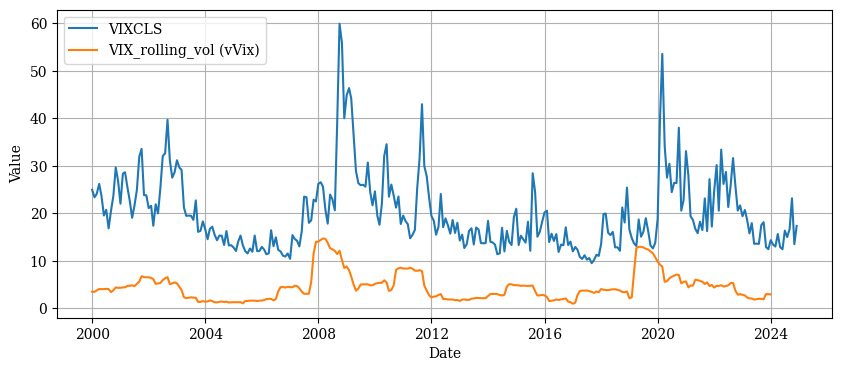

In [ ]:
plt.figure(figsize=(10, 4))  # Adjust figure size as needed
plt.plot(data_log.index, data_log['VIXCLS'], label='VIXCLS')
plt.plot(data_log.index, data_log['VIX_rolling_vol'], label='VIX_rolling_vol (vVix)')
plt.xlabel('Date')
plt.ylabel('Value')
# plt.title('VIXCLS and VIX_rolling_vol')  # Optional title
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data_log.shape

(300, 8)

## **ADF Test**

In [ ]:
def adf_test(series, name):
    result = adfuller(series.dropna(), autolag='AIC')
    return {
        'Variable': name,
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Stationary?': 'Yes' if result[1] < 0.05 else 'No'}

columns_to_test = ['wti_spot', 'wti_prod', 'INDPRO', 'ng_spot', 'lng_export', 'GEPU_current', 'VIX_rolling_vol']

adf_results = [adf_test(data_log[col], col) for col in columns_to_test]
adf_df = pd.DataFrame(adf_results)

print("ADF Test Results:")
print(adf_df)

ADF Test Results:
          Variable  ADF Statistic   p-value Stationary?
0         wti_spot      -2.029933  0.273605          No
1         wti_prod      -1.580834  0.493214          No
2           INDPRO      -1.959334  0.304683          No
3          ng_spot      -2.909656  0.044237         Yes
4       lng_export      -2.211233  0.202194          No
5     GEPU_current      -2.130622  0.232381          No
6  VIX_rolling_vol      -3.355450  0.012575         Yes


## **VAR**

In [ ]:
var_data = data_log[['wti_spot', 'wti_prod', 'INDPRO', 'lng_export', 'GEPU_current']].dropna()
var_data = var_data.reset_index(drop=True)

model = VAR(var_data)
lag_order_results = model.select_order(maxlags=6)
print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -1.679      -1.616      0.1866      -1.654
1      -12.01      -11.63   6.097e-06      -11.86
2      -12.90     -12.21*   2.497e-06     -12.62*
3      -13.01      -12.00   2.249e-06      -12.60
4     -13.02*      -11.70  2.228e-06*      -12.49
5      -12.96      -11.34   2.348e-06      -12.31
6      -12.99      -11.05   2.284e-06      -12.22
-------------------------------------------------


## **Johanesen cointegration**

In [ ]:
selected_lag = lag_order_results.bic

jres = coint_johansen(data_log[['wti_spot', 'wti_prod', 'INDPRO', 'lng_export',
                     'GEPU_current']].dropna(),
                      det_order=0,
                      k_ar_diff=selected_lag)
trace_stat = jres.lr1
crit_values = jres.cvt[:, 1]

for i, (ts, cv) in enumerate(zip(trace_stat, crit_values)):
    print(f"H0: r ≤ {i} | Trace Statistic = {ts:.2f}, Critical Value (5%) = {cv} → {'Reject' if ts > cv else 'Fail to Reject'}")

H0: r ≤ 0 | Trace Statistic = 64.57, Critical Value (5%) = 69.8189 → Fail to Reject
H0: r ≤ 1 | Trace Statistic = 28.38, Critical Value (5%) = 47.8545 → Fail to Reject
H0: r ≤ 2 | Trace Statistic = 16.47, Critical Value (5%) = 29.7961 → Fail to Reject
H0: r ≤ 3 | Trace Statistic = 9.40, Critical Value (5%) = 15.4943 → Fail to Reject
H0: r ≤ 4 | Trace Statistic = 2.97, Critical Value (5%) = 3.8415 → Fail to Reject


## **Eigen values**

In [ ]:
eigenvalues = jres.eig
eigen_df = pd.DataFrame({
    'r': range(len(eigenvalues)),
    'Eigenvalue': eigenvalues})
eigen_df

,r,Eigenvalue
0,0,0.114738
1,1,0.039310
2,2,0.023527
3,3,0.021419
4,4,0.009938


## **Cointe rank**

In [ ]:
coint_rank = 0
for i, (trace, crit) in enumerate(zip(trace_stat, crit_values)):
    if trace > crit:
        coint_rank = i + 1
    else:
        break

print("Cointegration Rank:", coint_rank)

Cointegration Rank: 0


based on the Johansen test results indicating one cointegration relationship, using a TVECM is recommended for our analysis

## **Threshold selection using grid search**

VIX Threshold Search: 100%|██████████| 80/80 [00:00<00:00, 171.78it/s]


Best VIX Threshold: 4.9276


GEPU Threshold Search: 100%|██████████| 70/70 [00:00<00:00, 99.98it/s] 


Best GEPU Threshold: 231.5341


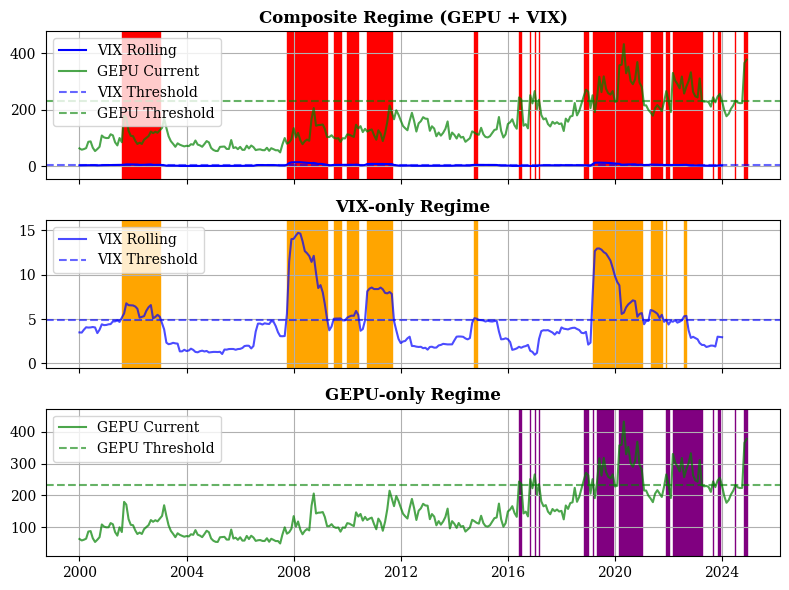


Threshold Summary:
Composite - GEPU: 231.53414562706345, VIX: 4.927569972295729
VIX-only: 4.927569972295729
GEPU-only: 231.53414562706345


In [ ]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", category=ValueWarning, module="statsmodels.tsa.base.tsa_model")

data_log = data_log.sort_index()
data_log.index = pd.DatetimeIndex(data_log.index, freq='MS')

best_threshold_pair = (None, None)

Y = data_log[['wti_spot', 'wti_prod', 'INDPRO', 'ng_spot', 'lng_export',
              'GEPU_current', 'VIX_rolling_vol']].dropna()
vix_var = data_log['VIX_rolling_vol'].dropna()
gepu_var = data_log['GEPU_current'].dropna()
selected_lag = 4

vix_var = vix_var.reindex(Y.index)
gepu_var = gepu_var.reindex(Y.index)

vix_threshold_grid = np.percentile(vix_var, np.arange(10, 90, 1))

best_threshold_vix = None
best_ssr_vix = np.inf

for thresh in tqdm(vix_threshold_grid, desc="VIX Threshold Search"):
    mask = vix_var <= thresh
    low = Y[mask]
    high = Y[~mask]

    if len(low) > selected_lag and len(high) > selected_lag:
        try:
            model_low = VAR(low).fit(selected_lag)
            model_high = VAR(high).fit(selected_lag)

            ssr = np.sum(model_low.resid.values**2) + np.sum(model_high.resid.values**2)

            if ssr < best_ssr_vix:
                best_ssr_vix = ssr
                best_threshold_vix = thresh

        except Exception as e:
            continue

if best_threshold_vix is not None:
    print(f"Best VIX Threshold: {best_threshold_vix:.4f}")
else:
    print("No suitable VIX threshold found.")

gepu_threshold_grid = np.percentile(gepu_var, np.arange(15, 85, 1))

best_threshold_gepu = None
best_ssr_gepu = np.inf

for thresh in tqdm(gepu_threshold_grid, desc="GEPU Threshold Search"):
    mask = gepu_var <= thresh
    low = Y[mask]
    high = Y[~mask]

    if len(low) > selected_lag and len(high) > selected_lag:
        try:
            model_low = VAR(low).fit(selected_lag)
            model_high = VAR(high).fit(selected_lag)

            ssr = np.sum(model_low.resid.values**2) + np.sum(model_high.resid.values**2)

            if ssr < best_ssr_gepu:
                best_ssr_gepu = ssr
                best_threshold_gepu = thresh

        except Exception as e:
            continue

if best_threshold_gepu is not None:
    print(f"Best GEPU Threshold: {best_threshold_gepu:.4f}")
else:
    print("No suitable GEPU threshold found.")

best_threshold_pair = (best_threshold_gepu, best_threshold_vix)

gepu_thresh, vix_thresh = best_threshold_pair
vix_only_thresh = best_threshold_vix
gepu_only_thresh = best_threshold_gepu

if gepu_thresh is not None and vix_thresh is not None:
    data_log['regime_composite'] = np.where(
        (data_log['GEPU_current'] > gepu_thresh) | (data_log['VIX_rolling_vol'] > vix_thresh), 1, 0)
else:
    data_log['regime_composite'] = 0

if vix_only_thresh is not None:
    data_log['regime_vix'] = np.where(data_log['VIX_rolling_vol'] > vix_only_thresh, 1, 0)
else:
    data_log['regime_vix'] = 0

if gepu_only_thresh is not None:
    data_log['regime_gepu'] = np.where(data_log['GEPU_current'] > gepu_only_thresh, 1, 0)
else:
    data_log['regime_gepu'] = 0

fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

if gepu_thresh is not None and vix_thresh is not None:
    axes[0].plot(data_log.index, data_log['VIX_rolling_vol'], label='VIX Rolling',
                 color='blue')
    axes[0].plot(data_log.index, data_log['GEPU_current'], label='GEPU Current', color='green', alpha=0.7)
    axes[0].axhline(y=vix_thresh, color='blue', linestyle='--', alpha=0.6, label='VIX Threshold')
    axes[0].axhline(y=gepu_thresh, color='green', linestyle='--', alpha=0.6, label='GEPU Threshold')
    axes[0].fill_between(data_log.index, 0, 1,
                         where=data_log['regime_composite'] == 1,
                         color='red', transform=axes[0].get_xaxis_transform())
    axes[0].set_title('Composite Regime (GEPU + VIX)', fontweight='bold')
    axes[0].legend()
    axes[0].grid()

if vix_only_thresh is not None:
    axes[1].plot(data_log.index, data_log['VIX_rolling_vol'], label='VIX Rolling', color='blue', alpha=0.7)
    axes[1].axhline(y=vix_only_thresh, color='blue', linestyle='--', label='VIX Threshold', alpha=0.6)
    axes[1].fill_between(data_log.index, 0, 1,
                         where=data_log['regime_vix'] == 1,
                         color='orange', transform=axes[1].get_xaxis_transform())
    axes[1].set_title('VIX-only Regime', fontweight='bold')
    axes[1].legend()
    axes[1].grid()

if gepu_only_thresh is not None:
    axes[2].plot(data_log.index, data_log['GEPU_current'], label='GEPU Current', color='green', alpha=0.7)
    axes[2].axhline(y=gepu_only_thresh, color='green', linestyle='--', label='GEPU Threshold', alpha=0.6)
    axes[2].fill_between(data_log.index, 0, 1,
                         where=data_log['regime_gepu'] == 1,
                         color='purple', transform=axes[2].get_xaxis_transform())
    axes[2].set_title('GEPU-only Regime', fontweight='bold')
    axes[2].legend()
    axes[2].grid()

plt.tight_layout()
plt.show()

print("\nThreshold Summary:")
print(f"Composite - GEPU: {gepu_thresh}, VIX: {vix_thresh}")
print(f"VIX-only: {vix_only_thresh}")
print(f"GEPU-only: {gepu_only_thresh}")

## **sup-Wald test (or Hansen’s threshold test) for:**

- VIX-only
- GEPU-only
- Composite

Compare p-values:

- If only VIX is significant → Use VIX-only.
- If both are significant → Use Composite.
- If GEPU insignificant → Drop GEPU.

In [ ]:
from scipy.stats import chi2

warnings.filterwarnings('ignore')

data_log = data_log.sort_index()
data_log.index = pd.DatetimeIndex(data_log.index, freq='MS')

Y = data_log[['wti_spot', 'wti_prod', 'INDPRO', 'ng_spot', 'lng_export',
              'GEPU_current', 'VIX_rolling_vol']].dropna()
vix_var = data_log['VIX_rolling_vol'].dropna()
gepu_var = data_log['GEPU_current'].dropna()
selected_lag = 4

vix_var = vix_var.reindex(Y.index)
gepu_var = gepu_var.reindex(Y.index)

def sup_wald_test(threshold_var, Y, selected_lag, grid_range=(10, 90, 1)):
    threshold_grid = np.percentile(threshold_var, np.arange(*grid_range))

    best_threshold = None
    best_ssr = np.inf
    ssr_null = None
    wald_stats = []

    try:
        model_null = VAR(Y).fit(selected_lag)
        ssr_null = np.sum(model_null.resid.values**2)
    except:
        return None, None, None

    for thresh in tqdm(threshold_grid, desc="Testing thresholds"):
        mask = threshold_var <= thresh
        low = Y[mask]
        high = Y[~mask]

        if len(low) > selected_lag and len(high) > selected_lag:
            try:
                model_low = VAR(low).fit(selected_lag)
                model_high = VAR(high).fit(selected_lag)

                ssr_alt = np.sum(model_low.resid.values**2) + np.sum(model_high.resid.values**2)

                n = len(Y)
                k = Y.shape[1] * selected_lag
                wald_stat = n * (ssr_null - ssr_alt) / ssr_alt
                wald_stats.append(wald_stat)

                if ssr_alt < best_ssr:
                    best_ssr = ssr_alt
                    best_threshold = thresh

            except:
                continue

    if not wald_stats:
        return None, None, None

    sup_wald = max(wald_stats)

    p_value = 1 - chi2.cdf(sup_wald, df=Y.shape[1] * selected_lag)

    return sup_wald, p_value, best_threshold

print("Running sup-Wald tests...\n")

print("Testing VIX-only threshold effect:")
sup_wald_vix, p_value_vix, threshold_vix = sup_wald_test(vix_var, Y, selected_lag)
print(f"VIX-only: Sup-Wald = {sup_wald_vix:.4f}, p-value = {p_value_vix:.4f}, Threshold = {threshold_vix:.4f}\n")

print("Testing GEPU-only threshold effect:")
sup_wald_gepu, p_value_gepu, threshold_gepu = sup_wald_test(gepu_var, Y, selected_lag, (15, 85, 1))
print(f"GEPU-only: Sup-Wald = {sup_wald_gepu:.4f}, p-value = {p_value_gepu:.4f}, Threshold = {threshold_gepu:.4f}\n")

print("Testing Composite threshold effect:")
if threshold_vix is None or threshold_gepu is None:
    if threshold_vix is None:
        threshold_vix = np.percentile(vix_var, 70)
    if threshold_gepu is None:
        threshold_gepu = np.percentile(gepu_var, 70)

composite_mask = (vix_var > threshold_vix) | (gepu_var > threshold_gepu)
low_composite = Y[~composite_mask]
high_composite = Y[composite_mask]

if len(low_composite) > selected_lag and len(high_composite) > selected_lag:
    try:
        model_low_comp = VAR(low_composite).fit(selected_lag)
        model_high_comp = VAR(high_composite).fit(selected_lag)

        ssr_alt_comp = (np.sum(model_low_comp.resid.values**2) +
                        np.sum(model_high_comp.resid.values**2))

        model_null = VAR(Y).fit(selected_lag)
        ssr_null = np.sum(model_null.resid.values**2)

        n = len(Y)
        k = Y.shape[1] * selected_lag
        wald_comp = n * (ssr_null - ssr_alt_comp) / ssr_alt_comp
        p_value_comp = 1 - chi2.cdf(wald_comp, df=k)

        print(f"Composite: Wald = {wald_comp:.4f}, p-value = {p_value_comp:.4f}")
        print(f"Thresholds: VIX = {threshold_vix:.4f}, GEPU = {threshold_gepu:.4f}\n")

    except Exception as e:
        print(f"Error in composite test: {e}")
        wald_comp, p_value_comp = None, None
else:
    print("Not enough observations for composite test")
    wald_comp, p_value_comp = None, None

print("=" * 50)
print("DECISION ANALYSIS:")
print("=" * 50)

significance_level = 0.05

if p_value_vix is not None and p_value_gepu is not None:
    vix_significant = p_value_vix < significance_level
    gepu_significant = p_value_gepu < significance_level

    print(f"VIX-only significant (p < 0.05): {vix_significant} (p = {p_value_vix:.4f})")
    print(f"GEPU-only significant (p < 0.05): {gepu_significant} (p = {p_value_gepu:.4f})")

    if vix_significant and gepu_significant:
        print("\n→ RECOMMENDATION: Use COMPOSITE regime (both VIX and GEPU are significant)")
        if p_value_comp is not None:
            print(f"   Composite test p-value: {p_value_comp:.4f}")

    elif vix_significant and not gepu_significant:
        print("\n→ RECOMMENDATION: Use VIX-ONLY regime (VIX significant, GEPU insignificant)")
        print("   → Drop GEPU from threshold analysis")

    elif not vix_significant and gepu_significant:
        print("\n→ RECOMMENDATION: Use GEPU-ONLY regime (GEPU significant, VIX insignificant)")
        print("   → Drop VIX from threshold analysis")

    else:
        print("\n→ RECOMMENDATION: No significant threshold effects found")
        print("   → Consider linear VAR model without thresholds")

elif p_value_vix is not None:
    vix_significant = p_value_vix < significance_level
    print(f"VIX-only significant (p < 0.05): {vix_significant} (p = {p_value_vix:.4f})")
    if vix_significant:
        print("\n→ RECOMMENDATION: Use VIX-ONLY regime")
    else:
        print("\n→ RECOMMENDATION: No significant threshold effects found")

elif p_value_gepu is not None:
    gepu_significant = p_value_gepu < significance_level
    print(f"GEPU-only significant (p < 0.05): {gepu_significant} (p = {p_value_gepu:.4f})")
    if gepu_significant:
        print("\n→ RECOMMENDATION: Use GEPU-ONLY regime")
    else:
        print("\n→ RECOMMENDATION: No significant threshold effects found")

else:
    print("No valid test results available")

print("=" * 50)

print("\nADDITIONAL DIAGNOSTICS:")
print(f"Sample size: {len(Y)}")
print(f"Number of variables: {Y.shape[1]}")
print(f"Selected lag order: {selected_lag}")
print(f"Significance level: {significance_level}")

Running sup-Wald tests...

Testing VIX-only threshold effect:


Testing thresholds: 100%|██████████| 80/80 [00:00<00:00, 119.64it/s]


VIX-only: Sup-Wald = 62.7968, p-value = 0.0002, Threshold = 4.9276

Testing GEPU-only threshold effect:


Testing thresholds: 100%|██████████| 70/70 [00:00<00:00, 114.78it/s]


GEPU-only: Sup-Wald = 318.6327, p-value = 0.0000, Threshold = 231.5341

Testing Composite threshold effect:
Composite: Wald = 113.0003, p-value = 0.0000
Thresholds: VIX = 4.9276, GEPU = 231.5341

DECISION ANALYSIS:
VIX-only significant (p < 0.05): True (p = 0.0002)
GEPU-only significant (p < 0.05): True (p = 0.0000)

→ RECOMMENDATION: Use COMPOSITE regime (both VIX and GEPU are significant)
   Composite test p-value: 0.0000

ADDITIONAL DIAGNOSTICS:
Sample size: 289
Number of variables: 7
Selected lag order: 4
Significance level: 0.05


In [ ]:
# data_stationary = data_log.copy()

# non_stationary_vars = adf_df[adf_df['Stationary?'] == 'No']['Variable'].tolist()

# for var in non_stationary_vars:
#     data_stationary[f'{var}_diff'] = data_stationary[var].diff().dropna()

# data_stationary = data_stationary.drop(columns=non_stationary_vars)
# stationary_vars = adf_df[adf_df['Stationary?'] == 'Yes']['Variable'].tolist()
# for var in stationary_vars:
#     data_stationary[var] = data_log[var].loc[data_stationary.index]

# columns_to_test_diff = [f'{var}_diff' for var in non_stationary_vars] + stationary_vars
# adf_results_diff = [adf_test(data_stationary[col].dropna(), col) for col in columns_to_test_diff]

# adf_diff_df = pd.DataFrame(adf_results_diff)

# print("\nADF Test Results after Differencing:")
# adf_diff_df

In [ ]:
composite_threshold = {'VIX': 4.9276, 'GEPU': 231.5341}

data_log['regime_composite'] = np.where(
    (data_log['VIX_rolling_vol'] > composite_threshold['VIX']) |
    (data_log['GEPU_current'] > composite_threshold['GEPU']), 1, 0)

low_regime_data = data_log[data_log['regime_composite'] == 0][['wti_spot', 'wti_prod', 'INDPRO', 'ng_spot', 'lng_export', 'GEPU_current', 'VIX_rolling_vol']]
high_regime_data = data_log[data_log['regime_composite'] == 1][['wti_spot', 'wti_prod', 'INDPRO', 'ng_spot', 'lng_export', 'GEPU_current', 'VIX_rolling_vol']]

print(f"Low regime obs: {low_regime_data.shape[0]}")
print(f"High regime obs: {high_regime_data.shape[0]}")

def optimal_lag_selection(data, maxlags=4):
    if len(data) <= maxlags + 1:
        return max(1, len(data)//4)
    try:
        model = VAR(data)
        sel = model.select_order(maxlags=maxlags)
        return int(sel.aic)
    except:
        return 1

lag_low = optimal_lag_selection(low_regime_data)
lag_high = optimal_lag_selection(high_regime_data)

print(f"\nOptimal lags - Low regime: {lag_low}, High regime: {lag_high}")

def fit_var_safely(data, lag_order):
    if len(data) <= lag_order + 1:
        lag_order = max(1, len(data) // 3)
        if len(data) <= lag_order + 1:
            return None

    try:
        data_diff = data.diff().dropna()

        data_diff += np.random.normal(0, 1e-8, data_diff.shape)

        model = VAR(data_diff)
        results = model.fit(lag_order, trend='c', method='ols')
        return results

    except Exception as e:
        print(f"Error fitting VAR: {e}")
        try:
            reduced_lag = max(1, lag_order - 1)
            model = VAR(data_diff)
            results = model.fit(reduced_lag, trend='c', method='ols')
            return results
        except:
            return None

var_low = fit_var_safely(low_regime_data, lag_low)
var_high = fit_var_safely(high_regime_data, lag_high)

if var_low is not None:
    print("\n" + "="*50)
    print("LOW REGIME VAR RESULTS")
    print("="*50)
    print(f"Sample size: {len(low_regime_data)}")
    print(f"Lag order: {var_low.k_ar}")
    print("\nSummary:")
    print(var_low.summary())
else:
    print("\nCould not estimate VAR for low regime - insufficient data or numerical issues")

if var_high is not None:
    print("\n" + "="*50)
    print("HIGH REGIME VAR RESULTS")
    print("="*50)
    print(f"Sample size: {len(high_regime_data)}")
    print(f"Lag order: {var_high.k_ar}")
    print("\nSummary:")
    print(var_high.summary())
else:
    print("\nCould not estimate VAR for high regime - insufficient data or numerical issues")

print("\n" + "="*50)
print("ADDITIONAL DIAGNOSTICS")
print("="*50)

if var_low is not None:
    print(f"\nLow regime - AIC: {var_low.aic:.4f}, BIC: {var_low.bic:.4f}")
    print(f"Residual std: {np.std(var_low.resid.values):.6f}")

if var_high is not None:
    print(f"\nHigh regime - AIC: {var_high.aic:.4f}, BIC: {var_high.bic:.4f}")
    print(f"Residual std: {np.std(var_high.resid.values):.6f}")

if var_low is not None and var_high is not None:
    print(f"\nRegime comparison:")
    print(f"AIC difference: {abs(var_low.aic - var_high.aic):.4f}")
    print(f"BIC difference: {abs(var_low.bic - var_high.bic):.4f}")


Low regime obs: 180
High regime obs: 120

Optimal lags - Low regime: 1, High regime: 1

LOW REGIME VAR RESULTS
Sample size: 180
Lag order: 1

Summary:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 13, Sep, 2025
Time:                     08:58:54
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -15.8809
Nobs:                     170.000    HQIC:                  -16.4947
Log likelihood:          -194.860    FPE:                4.51462e-08
AIC:                     -16.9138    Det(Omega_mle):     3.27208e-08
--------------------------------------------------------------------
Results for equation wti_spot
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.005366         0.007212      

In [ ]:
pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.4/249.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.7/145.7 kB 11.8 MB/s eta 0:00:00


In [ ]:
gics = pd.read_excel("/content/GICS.xlsx")
gics.head()

,Date,Energy,Utilities,IT,Materials,Industrials,ConsumerDiscretionary,ConsumerStaples,healthcare,Financials,CommunicationServices,RealEstate,sp500,wti_spot,VIX,FedFunds,inflation_yoy,UNRATE,INDPRO
0,2005-01-07,279.00,137.31,318.82,177.15,282.06,271.24,237.46,345.72,404.77,126.39,115.03,1186.19,44.07,13.49,2.14,0.028449,5.3,95.8785
1,2005-01-14,288.84,139.93,316.34,178.17,280.46,272.62,238.60,344.68,400.20,122.03,114.63,1184.52,46.79,12.43,2.25,0.028449,5.3,95.8785
2,2005-01-21,287.36,139.53,307.49,175.74,275.18,266.17,237.98,340.69,396.96,120.75,115.50,1167.87,47.85,14.36,2.28,0.028449,5.3,95.8785
3,2005-01-28,293.39,142.75,308.91,175.57,278.66,264.30,239.43,338.96,396.53,119.34,111.19,1171.36,48.56,13.24,2.27,0.028449,5.3,95.8785
4,2005-02-04,311.19,147.91,316.27,181.67,283.76,269.95,243.74,345.94,408.69,123.30,115.11,1203.03,46.97,11.21,2.43,0.030530,5.4,96.5709


In [ ]:
gics_returns = gics.set_index('Date').pct_change().dropna()
display(gics_returns.head())

,Energy,Utilities,IT,Materials,Industrials,ConsumerDiscretionary,ConsumerStaples,healthcare,Financials,CommunicationServices,RealEstate,sp500,wti_spot,VIX,FedFunds,inflation_yoy,UNRATE,INDPRO
Date,,,,,,,,,,,,,,,,,,
2005-01-14,0.035269,0.019081,-0.007779,0.005758,-0.005673,0.005088,0.004801,-0.003008,-0.011290,-0.034496,-0.003477,-0.001408,0.061720,-0.078577,0.051402,0.000000,0.000000,0.000000
2005-01-21,-0.005124,-0.002859,-0.027976,-0.013639,-0.018826,-0.023659,-0.002598,-0.011576,-0.008096,-0.010489,0.007590,-0.014056,0.022654,0.155270,0.013333,0.000000,0.000000,0.000000
2005-01-28,0.020984,0.023077,0.004618,-0.000967,0.012646,-0.007026,0.006093,-0.005078,-0.001083,-0.011677,-0.037316,0.002988,0.014838,-0.077994,-0.004386,0.000000,0.000000,0.000000
2005-02-04,0.060670,0.036147,0.023826,0.034744,0.018302,0.021377,0.018001,0.020592,0.030666,0.033183,0.035255,0.027037,-0.032743,-0.153323,0.070485,0.073168,0.018868,0.007222
2005-02-11,0.026190,-0.004462,-0.002182,0.006605,0.005603,-0.001371,-0.008205,0.003787,0.003646,-0.022628,0.021197,0.001887,-0.018948,0.019625,0.028807,0.000000,0.000000,0.000000


In [81]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pykalman import KalmanFilter
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# ================================
# Parameters
# ================================
window_size = 60  # rolling window size

# ================================
# Data Preparation
# ================================
print("Available columns in gics_returns:")
print(gics_returns.columns.tolist())

# Sector and macro variable lists
sector_columns = ['Energy', 'Utilities', 'IT', 'Materials', 'Industrials',
                  'ConsumerDiscretionary', 'ConsumerStaples', 'healthcare',
                  'Financials', 'CommunicationServices', 'RealEstate']
macro_columns = ['sp500', 'wti_spot', 'VIX', 'FedFunds', 'inflation_yoy', 'UNRATE', 'INDPRO']

# Verify columns
available_sectors = [col for col in sector_columns if col in gics_returns.columns]
available_macro = [col for col in macro_columns if col in gics_returns.columns]

print(f"\nAvailable sectors: {available_sectors}")
print(f"Available macro variables: {available_macro}")

# Extract WTI returns
wti_returns = gics_returns['wti_spot'].copy()

# ================================
# Rolling Regression Betas (full-length)
# ================================
rolling_betas = {}
for sector in available_sectors:
    full_beta_series = np.full(len(gics_returns), np.nan)  # full-length array

    for t in range(window_size, len(gics_returns)):
        y_window = gics_returns[sector].iloc[t-window_size:t]
        x_window = wti_returns.iloc[t-window_size:t]

        # Require at least 80% valid data
        valid_mask = ~(y_window.isna() | x_window.isna())
        if valid_mask.sum() < window_size * 0.8:
            continue

        y_clean = y_window[valid_mask]
        x_clean = x_window[valid_mask]

        if len(y_clean) > 10:
            X = sm.add_constant(x_clean)
            model = sm.OLS(y_clean, X, missing='drop').fit()
            if len(model.params) > 1:
                full_beta_series[t] = model.params[1]  # oil beta at time t

    rolling_betas[sector] = pd.Series(full_beta_series, index=gics_returns.index)

rolling_betas_df = pd.DataFrame(rolling_betas)

# ================================
# Kalman Filter Betas
# ================================
def kalman_filter_beta(y, x):
    """
    Compute time-varying regression beta using Kalman Filter.
    y: dependent variable array
    x: independent variable array
    Returns full-length array with NaNs for missing values.
    """
    mask = ~(np.isnan(y) | np.isnan(x))
    y_clean = y[mask]
    x_clean = x[mask]

    if len(y_clean) < 10:
        return np.full(len(y), np.nan)

    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)

    # Time-varying observation matrices: shape (n_timesteps, n_dim_obs, n_dim_state)
    obs_matrices = np.array([[[1.0, xi]] for xi in x_clean])  # shape (n_time, 1, 2)

    kf = KalmanFilter(
        transition_matrices=np.eye(2),
        observation_matrices=obs_matrices,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.eye(2),
        observation_covariance=1.0,
        transition_covariance=trans_cov)

    state_means, _ = kf.filter(y_clean)

    full_betas = np.full(len(y), np.nan)
    full_betas[mask] = state_means[:, 1]  # beta1 (oil beta)
    return full_betas


kalman_betas = {}
for sector in available_sectors:
    aligned_data = pd.DataFrame({
        'sector': gics_returns[sector],
        'wti': wti_returns
    }).dropna()

    if len(aligned_data) > 10:
        y = aligned_data['sector'].values
        x = aligned_data['wti'].values
        kalman_betas[sector] = pd.Series(
            kalman_filter_beta(y, x),
            index=aligned_data.index)
    else:
        kalman_betas[sector] = pd.Series(np.nan, index=gics_returns.index)

kalman_betas_df = pd.DataFrame(kalman_betas)

data_log.index = pd.to_datetime(data_log.index)
gics_returns.index = pd.to_datetime(gics_returns.index)

if 'regime_composite' in data_log.columns:
    regimes_aligned = data_log['regime_composite'].reindex(kalman_betas_df.index).dropna()
    low_regime_idx = regimes_aligned[regimes_aligned == 0].index
    high_regime_idx = regimes_aligned[regimes_aligned == 1].index

    regime_comparison = {}
    for sector in available_sectors:
        low_betas = kalman_betas_df.loc[low_regime_idx, sector].dropna()
        high_betas = kalman_betas_df.loc[high_regime_idx, sector].dropna()

        if len(low_betas) > 5 and len(high_betas) > 5:
            regime_comparison[sector] = {
                'Low_Regime_Mean': low_betas.mean(),
                'Low_Regime_Std': low_betas.std(),
                'High_Regime_Mean': high_betas.mean(),
                'High_Regime_Std': high_betas.std(),
                'Difference': high_betas.mean() - low_betas.mean()}

    regime_df = pd.DataFrame(regime_comparison).T
    print("\n" + "="*60)
    print("AVERAGE OIL BETAS (KALMAN FILTER) BY VOLATILITY REGIME")
    print("="*60)
    print(regime_df.round(4))

    # Statistical test
    print("\n" + "="*60)
    print("STATISTICAL SIGNIFICANCE OF REGIME DIFFERENCES (T-TEST)")
    print("="*60)
    significance_results = {}
    for sector in regime_df.index:
        low_vals = kalman_betas_df.loc[low_regime_idx, sector].dropna()
        high_vals = kalman_betas_df.loc[high_regime_idx, sector].dropna()
        t_stat, p_value = ttest_ind(low_vals, high_vals, nan_policy='omit')
        significance_results[sector] = {
            't_stat': t_stat,
            'p_value': p_value,
            'significant_5%': p_value < 0.05,
            'significant_1%': p_value < 0.01
        }

    significance_df = pd.DataFrame(significance_results).T
    print(significance_df.round(4))
else:
    print("\n'regime_composite' column not found in data_log. Cannot perform regime-specific comparison.")

# ================================
# Summary Statistics
# ================================
print("\n" + "="*60)
print("SUMMARY STATISTICS: OIL BETAS ACROSS SECTORS")
print("="*60)

print("\nRolling Regression Betas (60-month window):")
print(rolling_betas_df.describe().round(4))

print("\nKalman Filter Betas:")
print(kalman_betas_df.describe().round(4))

# Correlation between rolling and Kalman betas
correlation_results = {}
for sector in available_sectors:
    common_idx = rolling_betas_df[sector].dropna().index.intersection(
        kalman_betas_df[sector].dropna().index
    )
    if len(common_idx) > 10:
        corr = np.corrcoef(rolling_betas_df.loc[common_idx, sector],
                           kalman_betas_df.loc[common_idx, sector])[0, 1]
        correlation_results[sector] = corr

print(f"\nCorrelation between Rolling and Kalman Betas: {np.mean(list(correlation_results.values())):.4f}")

Available columns in gics_returns:
['Energy', 'Utilities', 'IT', 'Materials', 'Industrials', 'ConsumerDiscretionary', 'ConsumerStaples', 'healthcare', 'Financials', 'CommunicationServices', 'RealEstate', 'sp500', 'wti_spot', 'VIX', 'FedFunds', 'inflation_yoy', 'UNRATE', 'INDPRO']

Available sectors: ['Energy', 'Utilities', 'IT', 'Materials', 'Industrials', 'ConsumerDiscretionary', 'ConsumerStaples', 'healthcare', 'Financials', 'CommunicationServices', 'RealEstate']
Available macro variables: ['sp500', 'wti_spot', 'VIX', 'FedFunds', 'inflation_yoy', 'UNRATE', 'INDPRO']

AVERAGE OIL BETAS (KALMAN FILTER) BY VOLATILITY REGIME
                       Low_Regime_Mean  Low_Regime_Std  High_Regime_Mean  \
Energy                          0.1239          0.0644            0.0925   
Utilities                       0.0320          0.0199            0.0199   
IT                              0.0430          0.0329            0.0278   
Materials                       0.0721          0.0464           

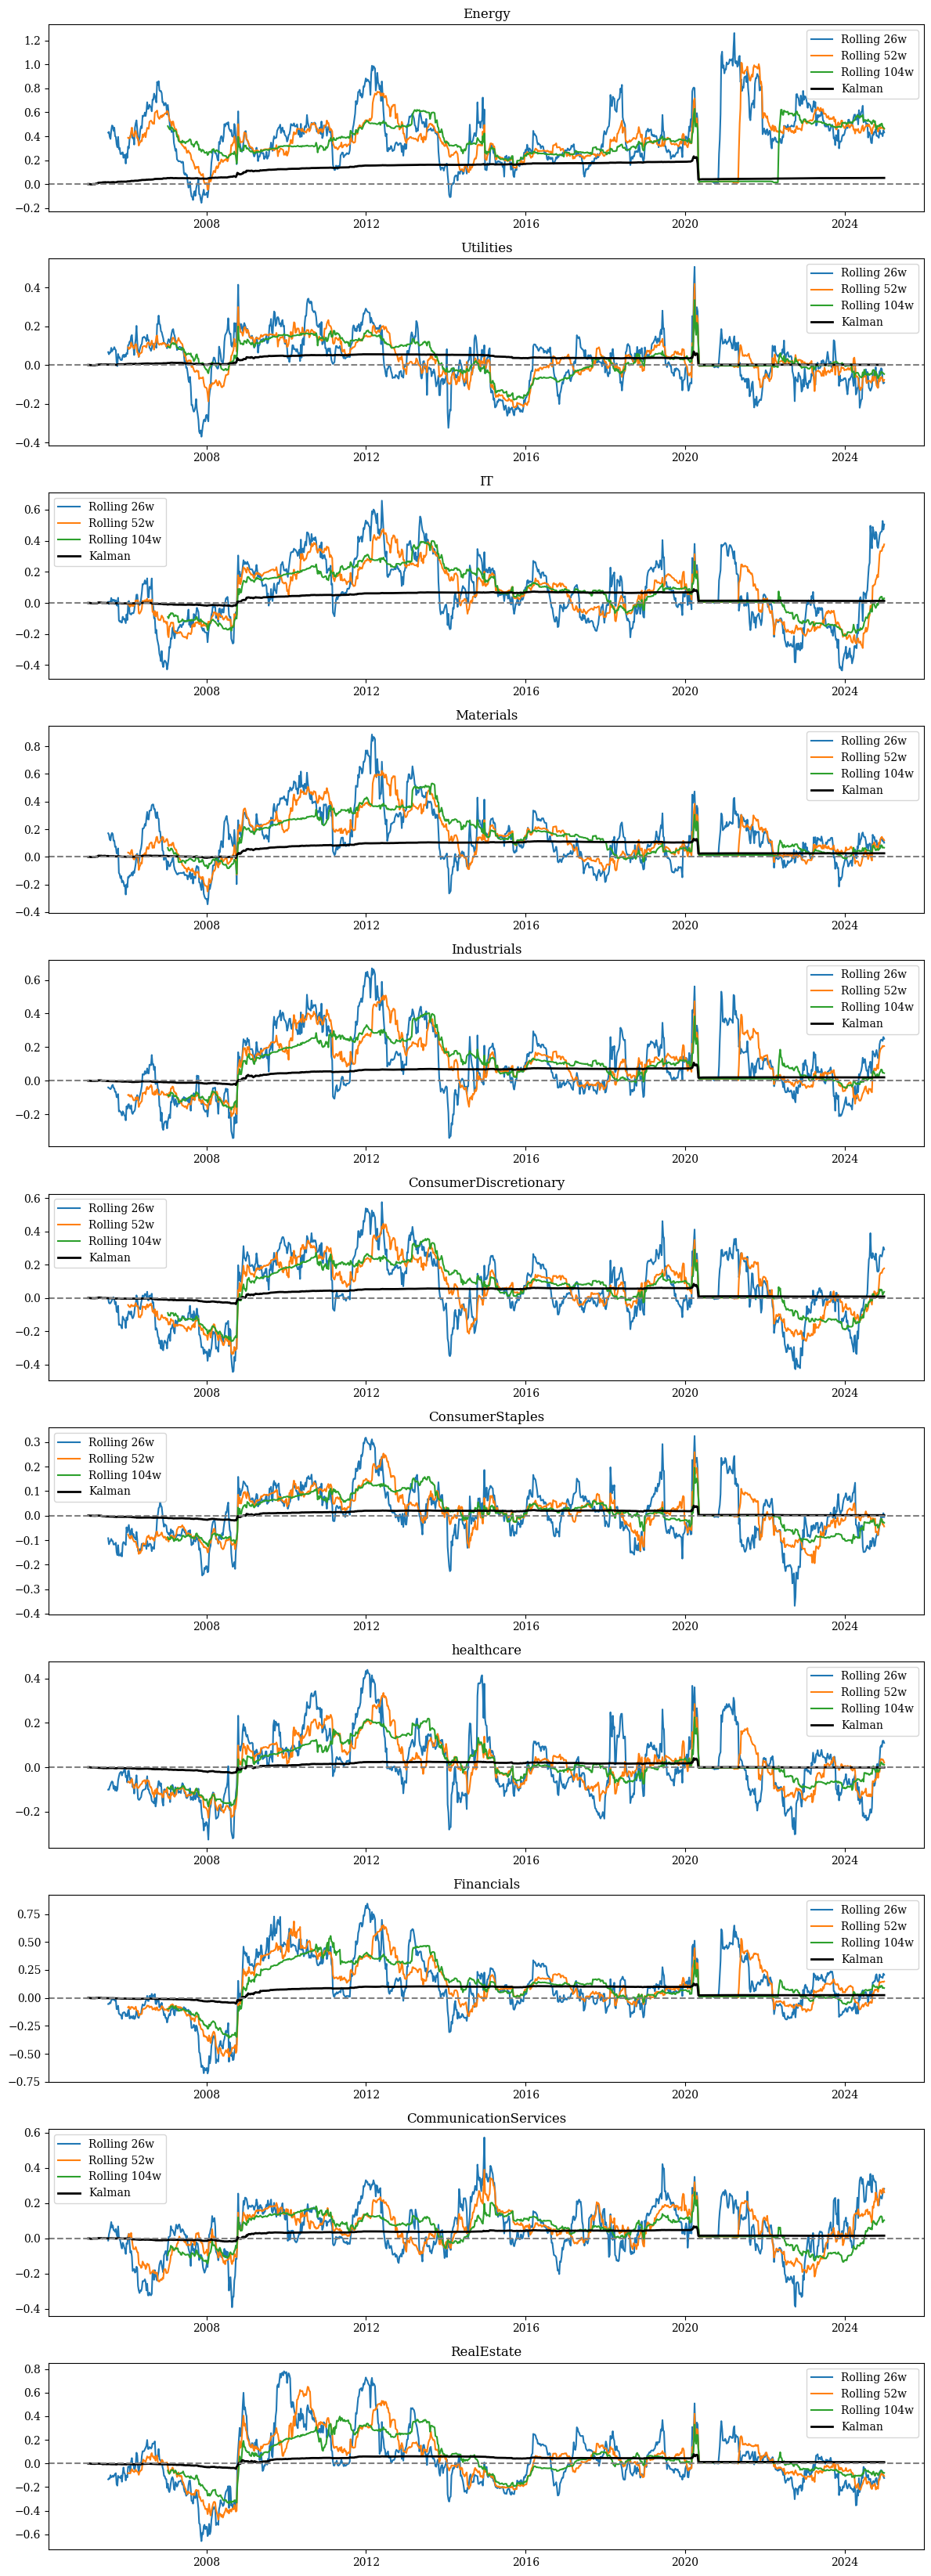

In [89]:
rolling_windows = [26, 52, 104]
sectors = ['Energy', 'Utilities', 'IT', 'Materials', 'Industrials',
           'ConsumerDiscretionary', 'ConsumerStaples', 'healthcare',
           'Financials', 'CommunicationServices', 'RealEstate']

wti_returns = gics_returns['wti_spot']

rolling_betas_dict = {}

for window in rolling_windows:
    rolling_betas = {}
    for sector in sectors:
        betas = []
        valid_dates = []
        for t in range(window, len(gics_returns)):
            y_window = gics_returns[sector].iloc[t-window:t]
            x_window = wti_returns.iloc[t-window:t]

            mask = ~(y_window.isna() | x_window.isna())
            if mask.sum() < window * 0.8:
                continue
            y_clean = y_window[mask]
            x_clean = x_window[mask]

            if len(y_clean) > 10:
                X = sm.add_constant(x_clean)
                model = sm.OLS(y_clean, X, missing='drop').fit()
                if len(model.params) > 1:
                    betas.append(model.params[1])
                    valid_dates.append(gics_returns.index[t])
        rolling_betas[sector] = pd.Series(betas, index=valid_dates)
    rolling_betas_dict[window] = pd.DataFrame(rolling_betas)

def kalman_filter_beta(y, x):
    """
    Compute time-varying regression beta using Kalman Filter.
    y: dependent variable array
    x: independent variable array
    Returns full-length array with NaNs for missing values.
    """
    mask = ~(np.isnan(y) | np.isnan(x))
    y_clean = y[mask]
    x_clean = x[mask]

    if len(y_clean) < 10:
        return np.full(len(y), np.nan)

    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)

    # Time-varying observation matrices: shape (n_timesteps, n_dim_obs, n_dim_state)
    obs_matrices = np.array([[[1.0, xi]] for xi in x_clean])  # shape (n_time, 1, 2)

    kf = KalmanFilter(
        transition_matrices=np.eye(2),
        observation_matrices=obs_matrices,
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.eye(2),
        observation_covariance=1.0,
        transition_covariance=trans_cov)

    state_means, _ = kf.filter(y_clean)

    full_betas = np.full(len(y), np.nan)
    full_betas[mask] = state_means[:, 1]  # beta1 (oil beta)
    return full_betas


kalman_betas = {}
for sector in available_sectors:
    aligned_data = pd.DataFrame({
        'sector': gics_returns[sector],
        'wti': wti_returns
    }).dropna()

    if len(aligned_data) > 10:
        y = aligned_data['sector'].values
        x = aligned_data['wti'].values
        kalman_betas[sector] = pd.Series(
            kalman_filter_beta(y, x),
            index=aligned_data.index)
    else:
        kalman_betas[sector] = pd.Series(np.nan, index=gics_returns.index)

kalman_betas_df = pd.DataFrame(kalman_betas)

fig, axes = plt.subplots(len(sectors), 1, figsize=(12, 3*len(sectors)))
if len(sectors) == 1:
    axes = [axes]

for i, sector in enumerate(sectors):
    ax = axes[i]
    for window in rolling_windows:
        df = rolling_betas_dict[window]
        if sector in df:
            ax.plot(df.index, df[sector], label=f'Rolling {window}w')
    if sector in kalman_betas_df.columns:
        ax.plot(kalman_betas_df.index, kalman_betas_df[sector], label='Kalman', color='black', linewidth=2)
    ax.set_title(sector)
    ax.axhline(0, color='gray', linestyle='--')
    ax.legend()

plt.tight_layout()
plt.show()

In [92]:
import pandas as pd

summary_rows = []

for sector in sectors:
    row = {'Sector': sector}

    for window in rolling_windows:
        df = rolling_betas_dict[window]
        if sector in df:
            row[f'Mean_{window}w'] = df[sector].mean()
            row[f'Std_{window}w'] = df[sector].std()
            row[f'Min_{window}w'] = df[sector].min()
            row[f'Max_{window}w'] = df[sector].max()
        else:
            row[f'Mean_{window}w'] = row[f'Std_{window}w'] = row[f'Min_{window}w'] = row[f'Max_{window}w'] = None

    if sector in kalman_betas_df:
        row['Mean_Kalman'] = kalman_betas_df[sector].mean()
        row['Std_Kalman'] = kalman_betas_df[sector].std()
        row['Min_Kalman'] = kalman_betas_df[sector].min()
        row['Max_Kalman'] = kalman_betas_df[sector].max()
    else:
        row['Mean_Kalman'] = row['Std_Kalman'] = row['Min_Kalman'] = row['Max_Kalman'] = None

    summary_rows.append(row)

summary_table = pd.DataFrame(summary_rows)
summary_table = summary_table.round(4)
summary_table


,Sector,Mean_26w,Std_26w,Min_26w,Max_26w,Mean_52w,Std_52w,Min_52w,Max_52w,Mean_104w,Std_104w,Min_104w,Max_104w,Mean_Kalman,Std_Kalman,Min_Kalman,Max_Kalman
0,Energy,0.3998,0.2347,-0.1553,1.2609,0.3718,0.1838,-0.0460,1.0139,0.3349,0.1539,0.0134,0.6291,0.1103,0.0605,-0.0012,0.2321
1,Utilities,0.0234,0.1270,-0.3686,0.5057,0.0252,0.0950,-0.2182,0.4178,0.0282,0.0813,-0.1785,0.3349,0.0273,0.0213,-0.0008,0.0695
2,IT,0.0691,0.2107,-0.4351,0.6580,0.0662,0.1691,-0.2905,0.4754,0.0707,0.1427,-0.2129,0.3996,0.0365,0.0301,-0.0201,0.0885
3,Materials,0.1379,0.2044,-0.3435,0.8854,0.1363,0.1674,-0.2509,0.6227,0.1418,0.1426,-0.1226,0.5312,0.0622,0.0429,-0.0082,0.1303
4,Industrials,0.0927,0.1891,-0.3422,0.6691,0.0915,0.1497,-0.2127,0.5076,0.0967,0.1202,-0.1734,0.4025,0.0392,0.0312,-0.0255,0.1070
5,ConsumerDiscretionary,0.0505,0.1953,-0.4447,0.5763,0.0518,0.1592,-0.3379,0.4461,0.0571,0.1346,-0.2602,0.3571,0.0295,0.0277,-0.0361,0.0848
6,ConsumerStaples,0.0039,0.1073,-0.3678,0.3248,0.0070,0.0803,-0.1942,0.2586,0.0120,0.0674,-0.1251,0.1957,0.0089,0.0117,-0.0201,0.0404
7,healthcare,0.0098,0.1450,-0.3270,0.4400,0.0081,0.1067,-0.2285,0.3357,0.0141,0.0878,-0.1775,0.2254,0.0080,0.0130,-0.0258,0.0408
8,Financials,0.0988,0.2598,-0.6758,0.8430,0.1007,0.2196,-0.5277,0.6844,0.1137,0.1778,-0.3592,0.5544,0.0562,0.0468,-0.0515,0.1278
9,CommunicationServices,0.0527,0.1495,-0.3921,0.5730,0.0491,0.1128,-0.2460,0.3902,0.0453,0.0812,-0.1441,0.2638,0.0243,0.0193,-0.0182,0.0678


In [99]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from sklearn.linear_model import LinearRegression

# Initialize summary table
summary_rows = []

for sector in sectors:
    row = {'Sector': sector}

    # Rolling windows: mean, std, min, max, skewness, kurtosis, trend
    for window in rolling_windows:
        df = rolling_betas_dict[window]
        if sector in df:
            series = df[sector].dropna()

            # # Basic statistics
            # row[f'Mean_{window}w'] = series.mean()
            # row[f'Std_{window}w'] = series.std()
            # row[f'Min_{window}w'] = series.min()
            # row[f'Max_{window}w'] = series.max()

            # Skewness and Kurtosis
            row[f'Skew_{window}w'] = skew(series)
            row[f'Kurt_{window}w'] = kurtosis(series)

            X = np.arange(len(series)).reshape(-1, 1)
            y = series.values
            model = LinearRegression().fit(X, y)
            row[f'Trend_{window}w'] = model.coef_[0]
        else:
            for metric in ['Skew', 'Kurt', 'Trend']:
                row[f'{metric}_{window}w'] = None

    if sector in kalman_betas_df:
        row['Mean_Kalman'] = kalman_betas_df[sector].mean()
        row['Std_Kalman'] = kalman_betas_df[sector].std()
        row['Min_Kalman'] = kalman_betas_df[sector].min()
        row['Max_Kalman'] = kalman_betas_df[sector].max()
    else:
        row['Mean_Kalman'] = row['Std_Kalman'] = row['Min_Kalman'] = row['Max_Kalman'] = None

    summary_rows.append(row)

summary_table = pd.DataFrame(summary_rows)
summary_table = summary_table.round(4)
print(summary_table)


                   Sector  Mean_26w  Std_26w  Min_26w  Max_26w  Skew_26w  \
0                  Energy    0.3998   0.2347  -0.1553   1.2609    0.4997   
1               Utilities    0.0234   0.1270  -0.3686   0.5057   -0.1531   
2                      IT    0.0691   0.2107  -0.4351   0.6580    0.1932   
3               Materials    0.1379   0.2044  -0.3435   0.8854    0.7292   
4             Industrials    0.0927   0.1891  -0.3422   0.6691    0.5145   
5   ConsumerDiscretionary    0.0505   0.1953  -0.4447   0.5763   -0.0539   
6         ConsumerStaples    0.0039   0.1073  -0.3678   0.3248    0.1944   
7              healthcare    0.0098   0.1450  -0.3270   0.4400    0.5521   
8              Financials    0.0988   0.2598  -0.6758   0.8430    0.1140   
9   CommunicationServices    0.0527   0.1495  -0.3921   0.5730   -0.1402   
10             RealEstate    0.0281   0.2396  -0.6568   0.7803    0.6411   

    Kurt_26w  Trend_26w  Mean_52w  Std_52w  ...  Std_104w  Min_104w  Max_104w  \
0     

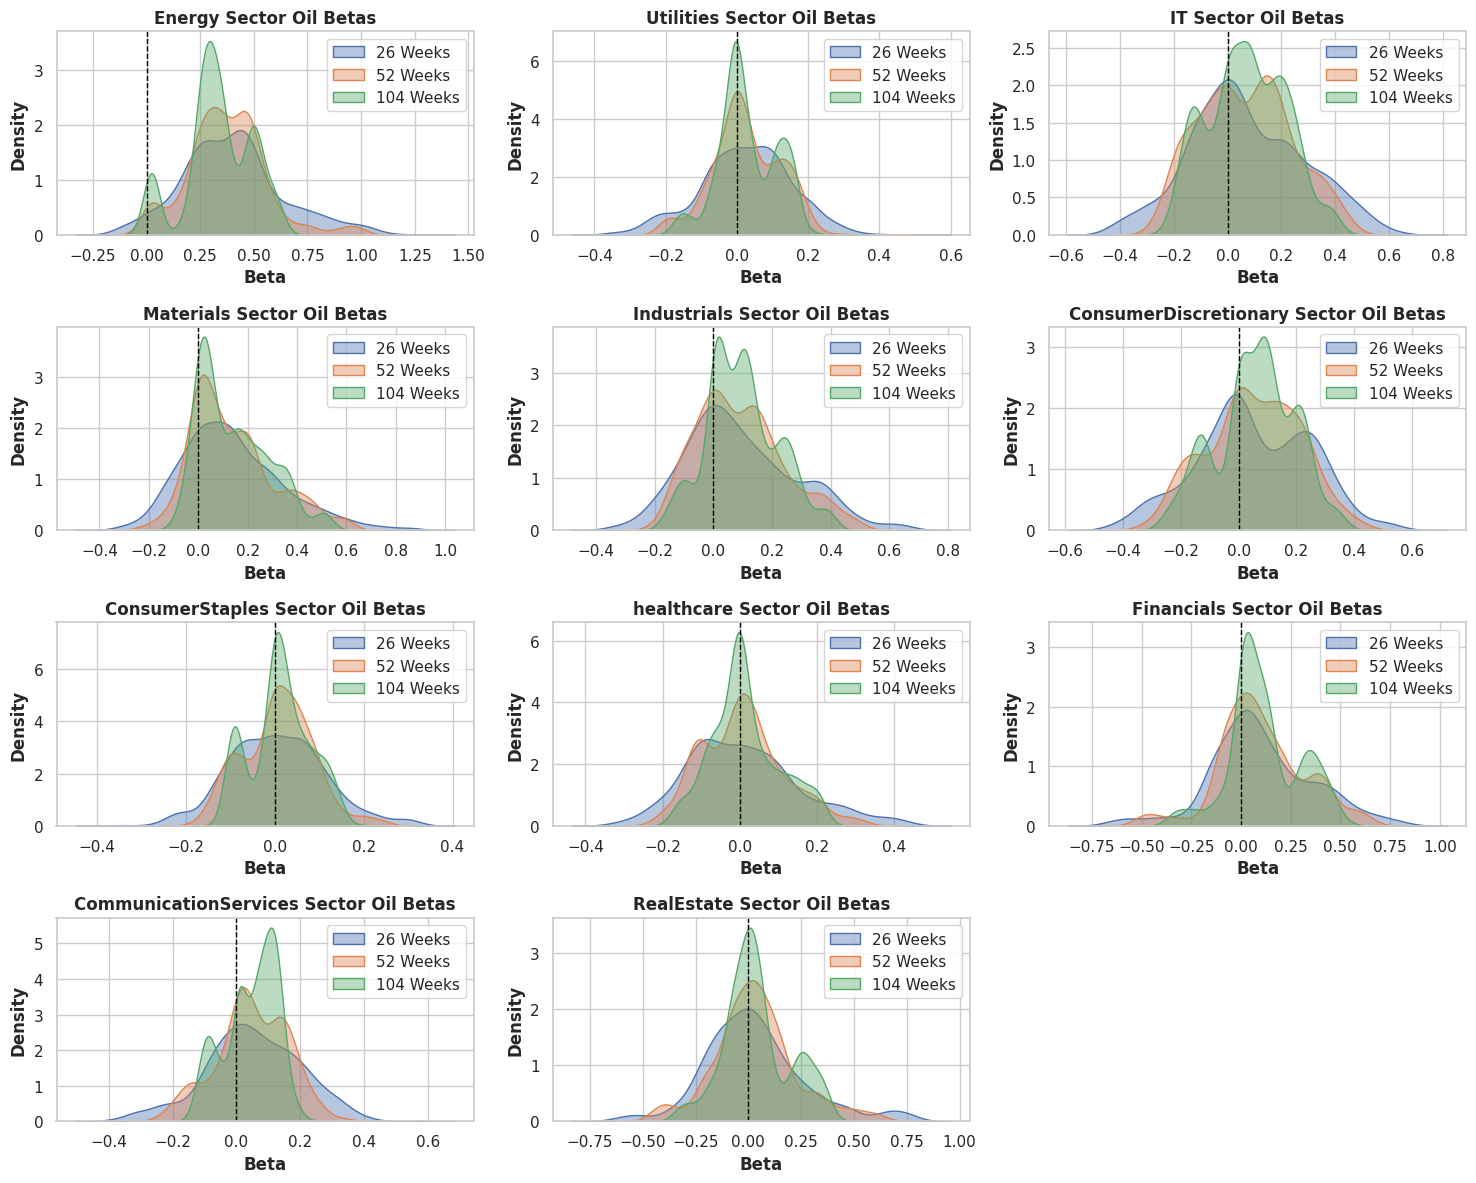

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

rolling_windows = [26, 52, 104]
window_labels = {26: '26 Weeks', 52: '52 Weeks', 104: '104 Weeks'}
sectors = ['Energy', 'Utilities', 'IT', 'Materials', 'Industrials',
           'ConsumerDiscretionary', 'ConsumerStaples', 'healthcare',
           'Financials', 'CommunicationServices', 'RealEstate']

fig, axes = plt.subplots(4, 3, figsize=(15, 12))
axes = axes.flatten()

# Remove the last unused subplot
fig.delaxes(axes[-1])

for i, sector in enumerate(sectors):
    ax = axes[i]
    for window in rolling_windows:
        rolling_betas_df = rolling_betas_dict[window]
        if sector in rolling_betas_df.columns:
            sns.kdeplot(
                rolling_betas_df[sector].dropna(),
                label=window_labels[window],
                fill=True,
                alpha=0.4,
                ax=ax
            )
    ax.set_title(f'{sector} Sector Oil Betas', fontweight='bold')
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('Beta', fontweight='bold')
    ax.set_ylabel('Density', fontweight='bold')
    ax.legend()

plt.tight_layout()
# plt.suptitle('Distribution of Sectoral Oil Betas Across Rolling Windows', y=1.02, fontsize=16)
plt.show()

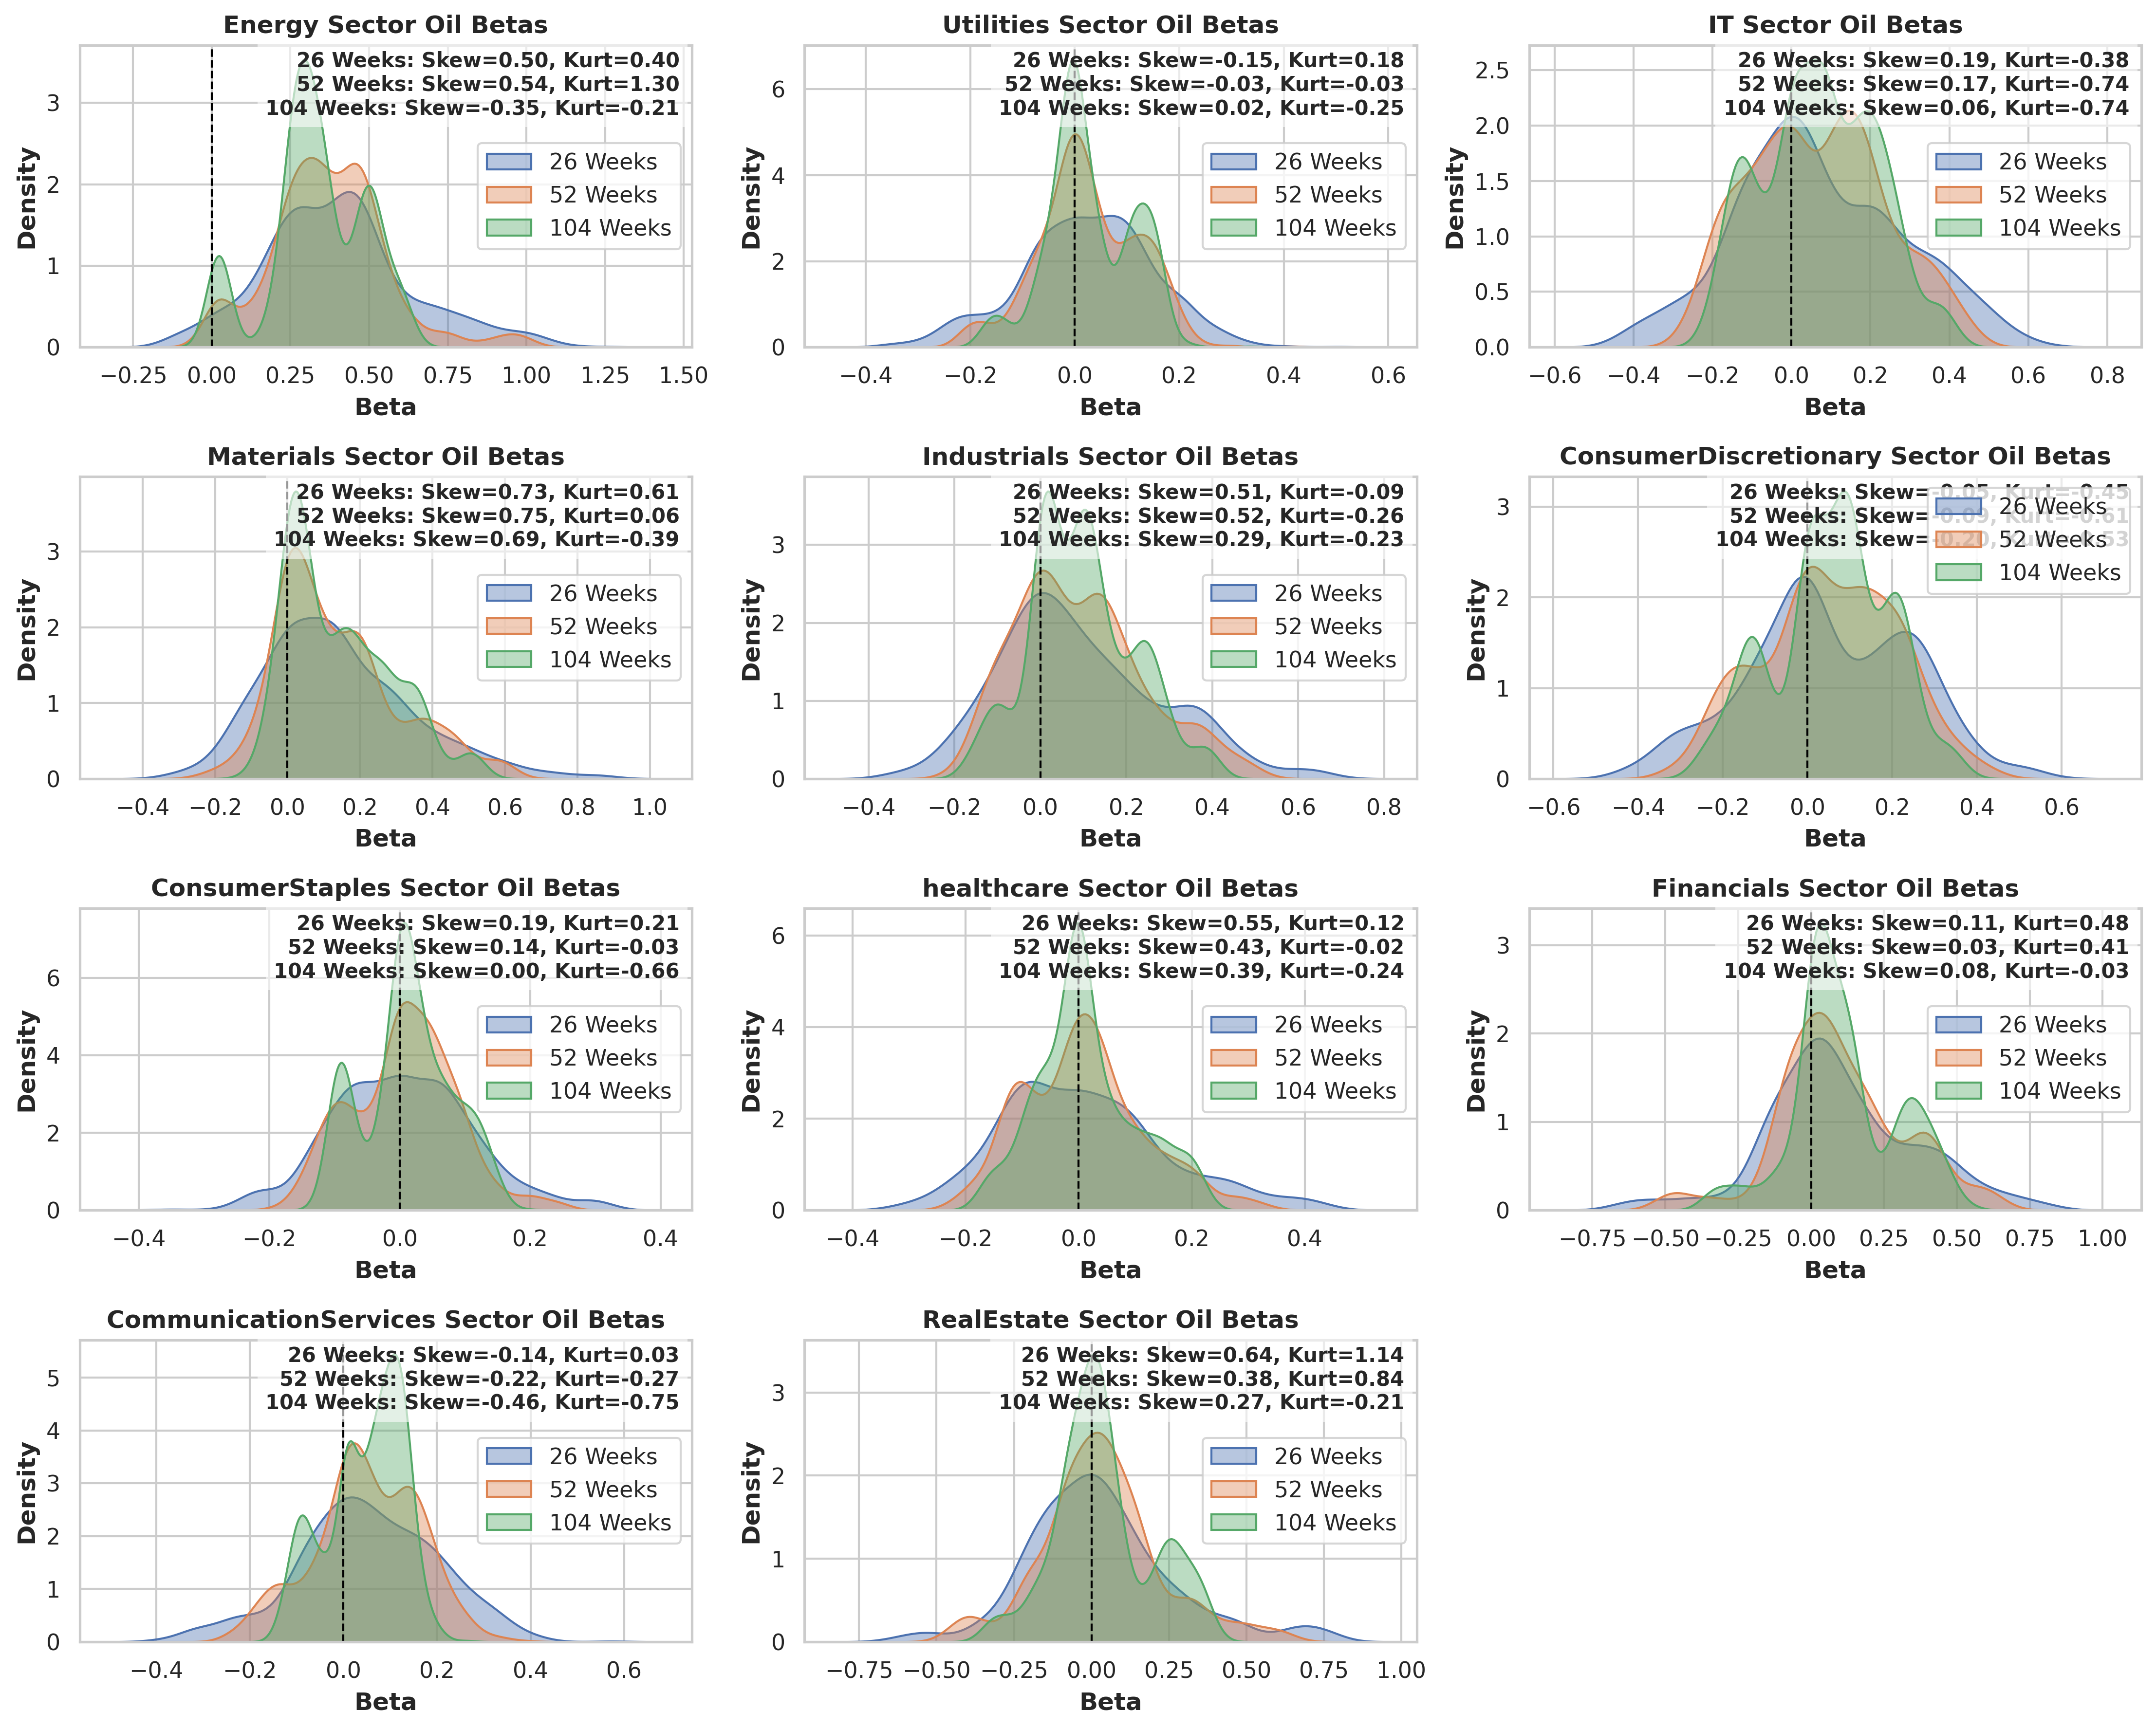

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import skew, kurtosis

sns.set(style="whitegrid")

rolling_windows = [26, 52, 104]
window_labels = {26: '26 Weeks', 52: '52 Weeks', 104: '104 Weeks'}
sectors = ['Energy', 'Utilities', 'IT', 'Materials', 'Industrials',
           'ConsumerDiscretionary', 'ConsumerStaples', 'healthcare',
           'Financials', 'CommunicationServices', 'RealEstate']

fig, axes = plt.subplots(4, 3, figsize=(15, 12), dpi=300)
axes = axes.flatten()

fig.delaxes(axes[-1])

for i, sector in enumerate(sectors):
    ax = axes[i]
    text_lines = []
    for window in rolling_windows:
        rolling_betas_df = rolling_betas_dict[window]
        if sector in rolling_betas_df.columns:
            data = rolling_betas_df[sector].dropna()
            if len(data) > 1:
                sns.kdeplot(data, label=window_labels[window],
                            fill=True, alpha=0.4, ax=ax)

                skew_val = skew(data)
                kurt_val = kurtosis(data)

                text_lines.append(f"{window_labels[window]}: Skew={skew_val:.2f}, Kurt={kurt_val:.2f}")

    ax.set_title(f'{sector} Sector Oil Betas', fontweight='bold')
    ax.axvline(0, color='black', linestyle='--', linewidth=1)
    ax.set_xlabel('Beta', fontweight='bold')
    ax.set_ylabel('Density', fontweight='bold')
    ax.legend()

    if text_lines:
        ax.text(0.98, 0.98, "\n".join(text_lines),
                transform=ax.transAxes, fontsize=10, fontweight='bold',
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.tight_layout()
plt.show()

In [79]:
from scipy.stats import skew, kurtosis
from scipy.stats import shapiro
from scipy.stats import kstest, norm

sector = 'Energy'  # example sector
beta_series = kalman_betas_df[sector].dropna()

print(f"{sector} - Skewness: {skew(beta_series):.3f}, Kurtosis: {kurtosis(beta_series):.3f}")


stat, p = shapiro(beta_series)
print(f'Shapiro-Wilk Test: stat={stat:.3f}, p={p:.3f}')
if p > 0.05:
    print("Fail to reject H0: Data looks normal")
else:
    print("Reject H0: Data is not normal")



beta_std = (beta_series - beta_series.mean()) / beta_series.std()
stat, p = kstest(beta_std, 'norm')
print(f'KS Test: stat={stat:.3f}, p={p:.3f}')


Energy - Skewness: -0.146, Kurtosis: -1.647
Shapiro-Wilk Test: stat=0.853, p=0.000
Reject H0: Data is not normal
KS Test: stat=0.223, p=0.000


In [80]:
from scipy.stats import mannwhitneyu

regimes_aligned = data_log['regime_composite'].reindex(kalman_betas_df.index).dropna()
low_regime_idx = regimes_aligned[regimes_aligned == 0].index
high_regime_idx = regimes_aligned[regimes_aligned == 1].index


nonparam_results = {}
for sector in available_sectors:
    low_betas = kalman_betas_df.loc[low_regime_idx, sector].dropna()
    high_betas = kalman_betas_df.loc[high_regime_idx, sector].dropna()

    if len(low_betas) > 5 and len(high_betas) > 5:
        stat, p_value = mannwhitneyu(low_betas, high_betas, alternative='two-sided')
        nonparam_results[sector] = {
            'U_stat': stat,
            'p_value': p_value,
            'significant_5%': p_value < 0.05,
            'significant_1%': p_value < 0.01
        }


nonparam_df = pd.DataFrame(nonparam_results).T
print("\n" + "="*60)
print("NON-PARAMETRIC TEST (MANN-WHITNEY U) FOR REGIME DIFFERENCES")
print("="*60)
print(nonparam_df.round(4))



NON-PARAMETRIC TEST (MANN-WHITNEY U) FOR REGIME DIFFERENCES
                      U_stat   p_value significant_5% significant_1%
Energy                 203.0  0.193879          False          False
Utilities              216.0  0.087058          False          False
IT                     195.0  0.295705          False          False
Materials              208.0  0.144943          False          False
Industrials            195.0  0.295705          False          False
ConsumerDiscretionary  195.0  0.295705          False          False
ConsumerStaples        216.0  0.087058          False          False
healthcare             216.0  0.087058          False          False
Financials             216.0  0.087058          False          False
CommunicationServices  194.0  0.310582          False          False
RealEstate             203.0  0.193879          False          False
